# Exploring Principal Component Analysis (PCA)

In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA = './data'
batch_size = 32
dataset_name = "mnist"

if dataset_name == "fmnist":
    trainset = FashionMNIST(DATA, train=True, transform=None, target_transform=None, download=True)
    testset = FashionMNIST(DATA, train=False, transform=None, target_transform=None, download=True)
else:
    trainset = MNIST(DATA, train=True, transform=None, target_transform=None, download=True)
    testset = MNIST(DATA, train=False, transform=None, target_transform=None, download=True)

In [2]:
def dataset_to_Xy(dataset):
    if dataset_name in {"mnist", "fmnist"}:
        min = 0
        max = 255
        new_min = -1.
        new_max = 1.

        N = dataset.data.numpy().shape[0]
        
        X = (np.reshape(dataset.data.numpy(), (N, 784)) - min) * (new_max - new_min) / (max - min) + new_min
        y = dataset.targets.numpy()
    else:
        raise NotImplementedError("The specified dataset is not currently supported.")

    return X.T, y

def standardize_X(X, mu=None, stds=None):
    if mu is None:
        mu = np.mean(X, axis=1)
        mu = mu.reshape((mu.size, 1))

    if stds is None:
        stds = np.std(X, axis=1)
        stds = stds.reshape((stds.size, 1))
        
    return (X - mu) / (stds + 1e-12), mu, stds

def standardize_Xs(Xs_raw, orig_mus=None, orig_stdss=None):
    Xs = []
    mus = []
    stdss = []
    for i, (X, y) in enumerate(Xs_raw):
        if orig_mus is not None and orig_stdss is not None:
            X_standardized, mu, stds = standardize_X(X, orig_mus[i], orig_stdss[i])
        else:
            X_standardized, mu, stds = standardize_X(X)
            
        Xs.append((X_standardized, y))
        mus.append(mu)
        stdss.append(stds)

    return Xs, mus, stdss

def split_by_label(X, y):
    Xs = []
    for label in set(y):
        idxs = [l == label for l in y]
        X_label = X.T[idxs]
        Xs.append((X_label.T, label))

    return Xs

def cov_by_label(Xs):
    covs = []
    for X, y in Xs:
        # Assuming D x N_label
        N = X.shape[1]
        covs.append(((1/N)*X@X.T, y))

    return covs

X_raw, y = dataset_to_Xy(trainset)

# Stratified by label
Xs_raw = split_by_label(X_raw, y)
Xs_strat, mus, stdss = standardize_Xs(Xs_raw)
Ss = cov_by_label(Xs_strat)

# We center and standardize X to simplify the PCA algorithm
X, mu, stds = standardize_X(X_raw)
# Xs = split_by_label(X, y)
# Ss = cov_by_label(Xs)
N = X.shape[1]
S = (1 / N) * X@X.T

# Processing elements standardized on whole dataset
X_test_raw, y_test = dataset_to_Xy(testset)
X_test, _, _ = standardize_X(X_test_raw, mu, stds)
Xs_test = split_by_label(X_test, y_test)

# Finally for elements standardized by label
Xs_test_raw = split_by_label(X_test_raw, y_test)
Xs_strat_test, _, _ = standardize_Xs(Xs_test_raw)

8


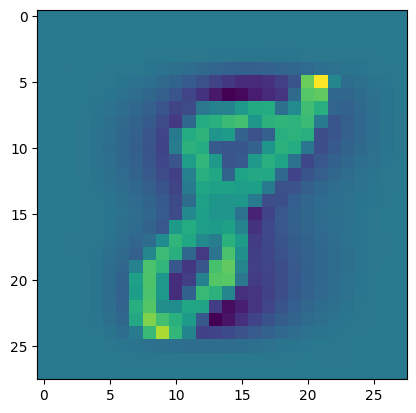

In [3]:
print(Xs_strat[8][1])
plt.imshow(Xs_strat[8][0][:,0].reshape((28,28)))

## Considering Eigenvalues and Variance of Handwritten Digit 8

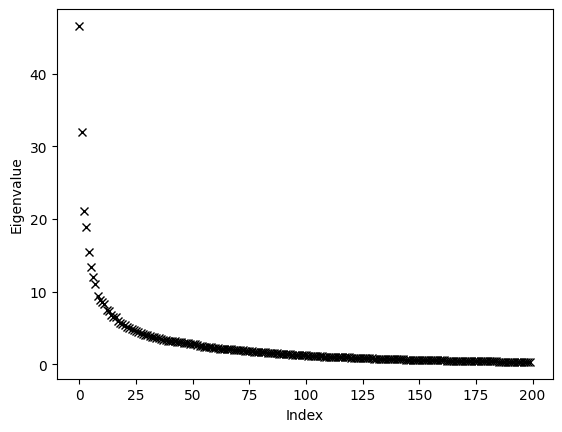

In [4]:
strat_eig_vals, strat_eig_vecs = np.linalg.eigh(Ss[8][0])
idxs = np.flip(np.argsort(strat_eig_vals))[:200]
strat_ordered_eigvals = np.flip(np.sort(strat_eig_vals[-200:]))
strat_ordered_eigvecs = strat_eig_vecs[:,idxs]
plt.figure()
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.plot(strat_ordered_eigvals, 'x', color='black')

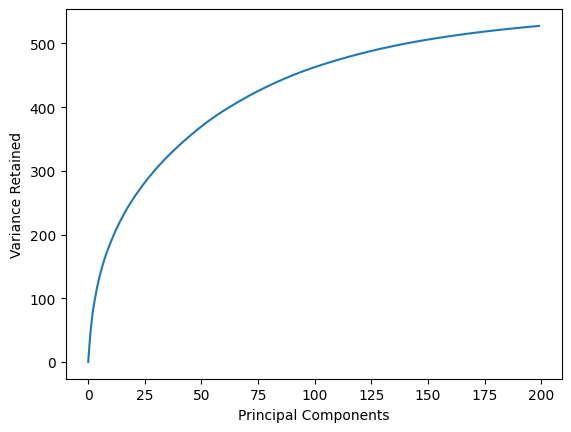

In [5]:
plt.figure()
plt.xlabel("Principal Components")
plt.ylabel("Variance Retained")
plt.plot([np.sum(strat_ordered_eigvals[:i]) for i, _ in enumerate(strat_ordered_eigvals)])

In [6]:
M = 10
print(strat_ordered_eigvecs.shape)
strat_B = strat_ordered_eigvecs[:,:M]
print(Xs_strat_test[8][0].shape)
print(strat_B.shape)

print(idxs)

(784, 200)
(784, 974)
(784, 10)
[783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766
 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 749 748
 747 746 745 744 743 742 741 740 739 738 737 736 735 734 733 732 731 730
 729 728 727 726 725 724 723 722 721 720 719 718 717 716 715 714 713 712
 711 710 709 708 707 706 705 704 703 702 701 700 699 698 697 696 695 694
 693 692 691 690 689 688 687 686 685 684 683 682 681 680 679 678 677 676
 675 674 673 672 671 670 669 668 667 666 665 664 663 662 661 660 659 658
 657 656 655 654 653 652 651 650 649 648 647 646 645 644 643 642 641 640
 639 638 637 636 635 634 633 632 631 630 629 628 627 626 625 624 623 622
 621 620 619 618 617 616 615 614 613 612 611 610 609 608 607 606 605 604
 603 602 601 600 599 598 597 596 595 594 593 592 591 590 589 588 587 586
 585 584]


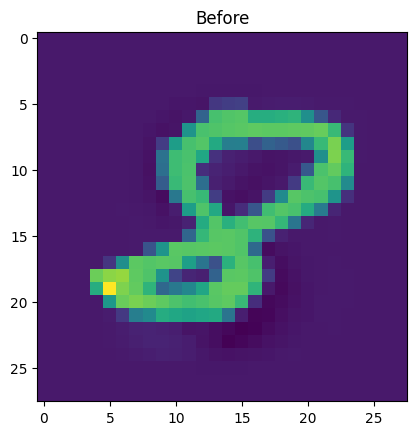

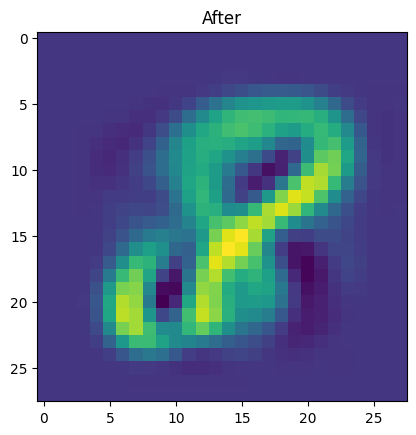

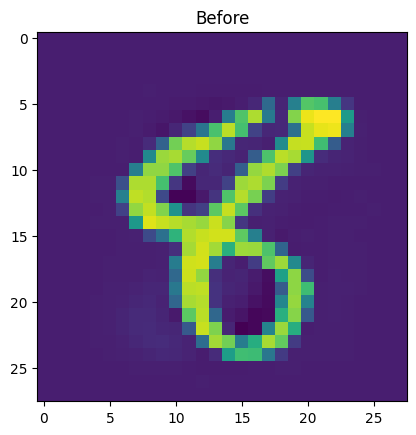

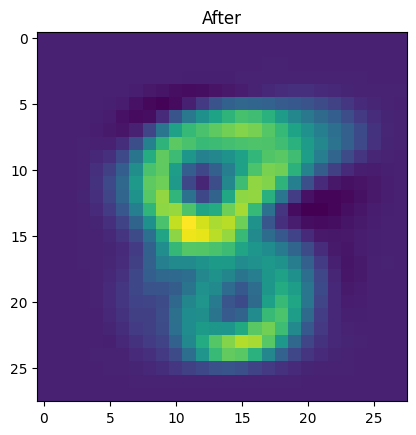

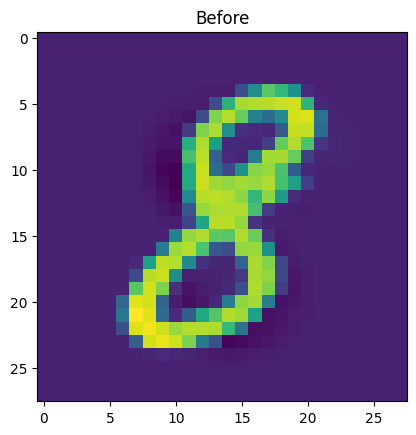

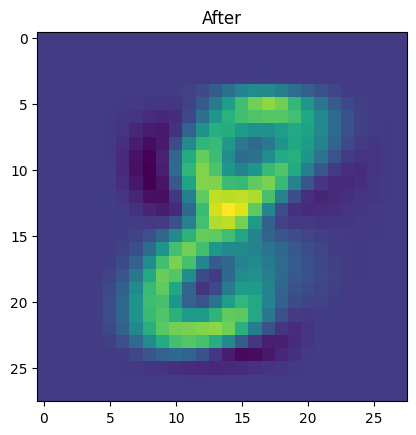

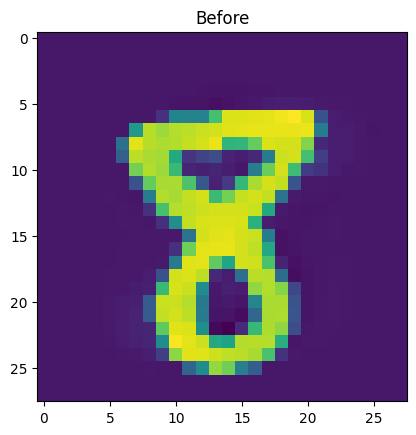

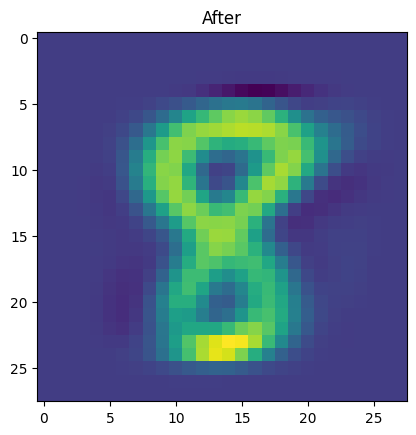

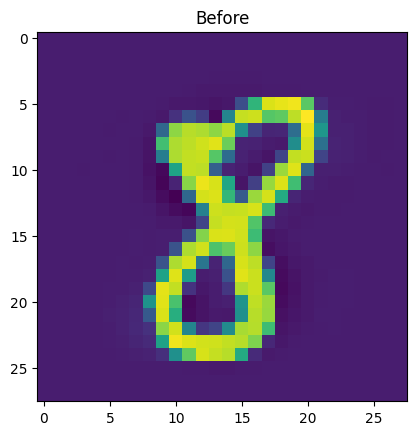

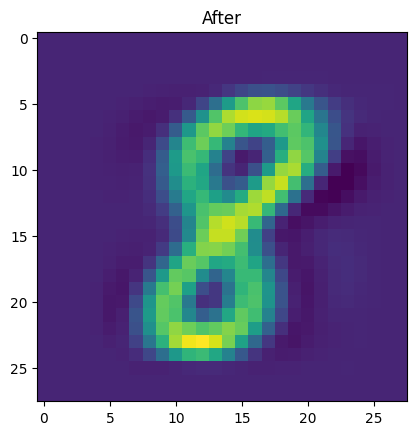

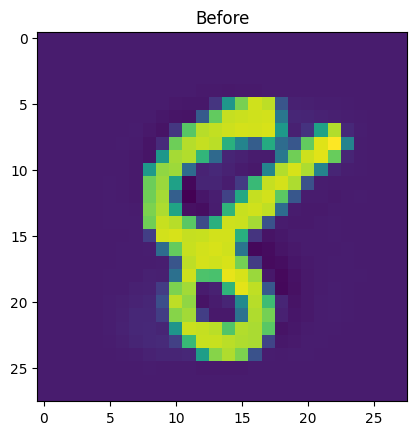

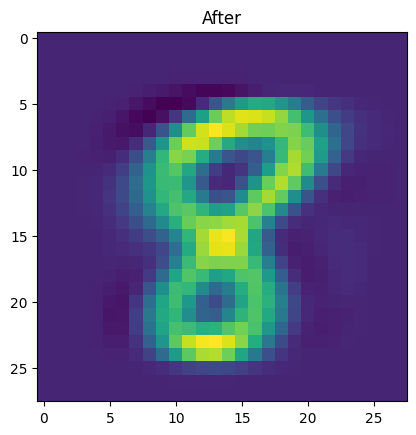

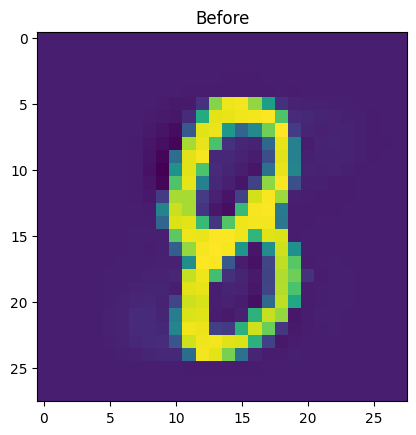

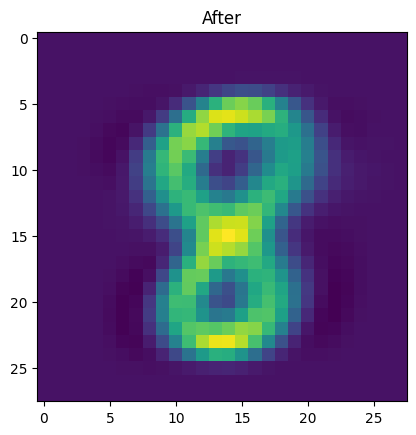

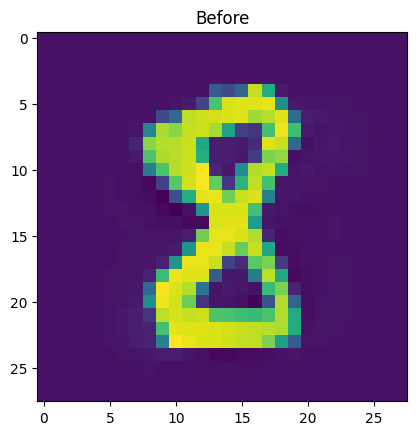

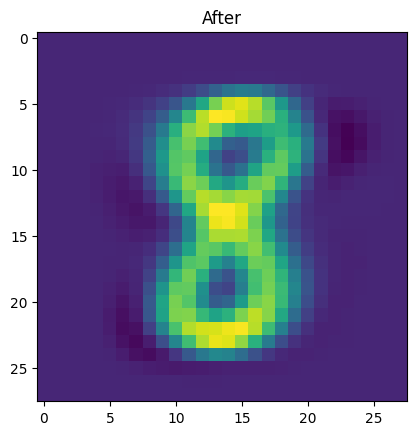

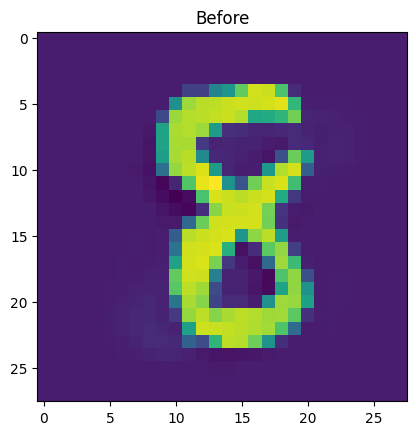

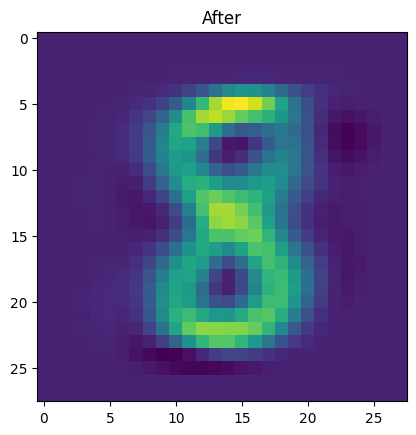

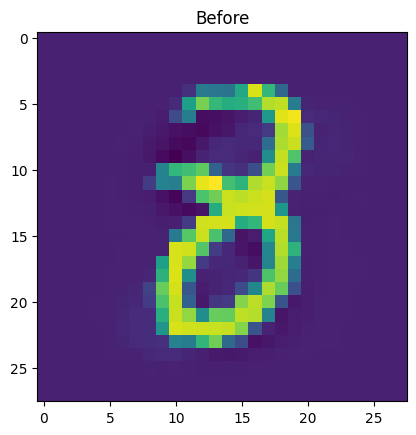

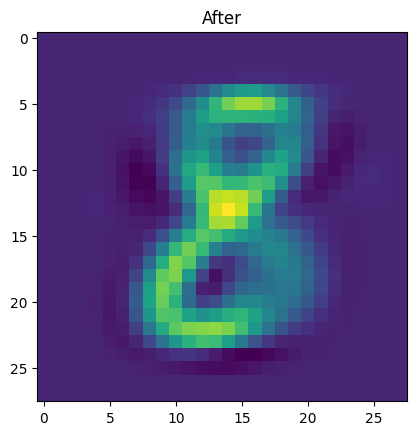

In [7]:
num_ex = 10

for i in range(num_ex):
    plt.figure()
    plt.title("Before")
    plt.imshow((Xs_strat_test[8][0][:,i].reshape((Xs_strat_test[8][0][:,i].size, 1))*stdss[8]+mus[8]).reshape((28,28)))
    
    # Compute encoding
    z = strat_B.T@Xs_strat_test[8][0][:,i]

    # Compute decoding
    x_tilde = strat_B@z

    plt.figure()
    plt.title("After")
    plt.imshow((x_tilde.reshape((x_tilde.size, 1))*stdss[8]+mus[8]).reshape((28,28)))

## Now on Whole Dataset

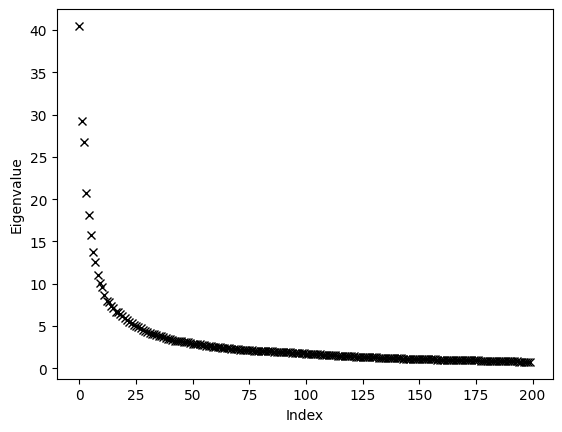

In [8]:
eig_vals, eig_vecs = np.linalg.eigh(S)
idxs = np.flip(np.argsort(eig_vals))[:200]
ordered_eigvals = np.flip(np.sort(eig_vals[-200:]))
ordered_eigvecs = eig_vecs[:,idxs]
plt.figure()
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.plot(ordered_eigvals, 'x', color='black')

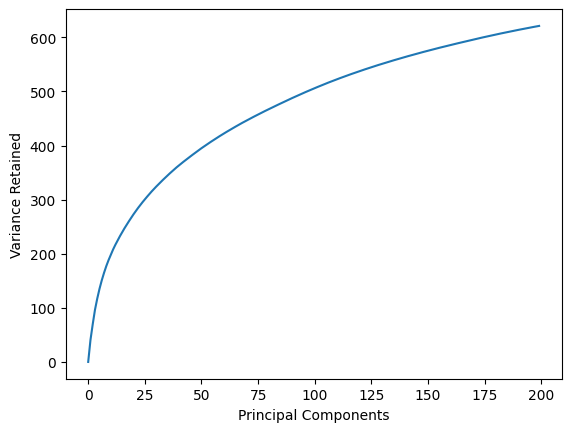

In [9]:
plt.figure()
plt.xlabel("Principal Components")
plt.ylabel("Variance Retained")
plt.plot([np.sum(ordered_eigvals[:i]) for i, _ in enumerate(ordered_eigvals)])

In [10]:
M = 10
B = ordered_eigvecs[:,:M]
print(X_test.shape)
print(B.shape)

print(idxs)

(784, 10000)
(784, 10)
[783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766
 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 749 748
 747 746 745 744 743 742 741 740 739 738 737 736 735 734 733 732 731 730
 729 728 727 726 725 724 723 722 721 720 719 718 717 716 715 714 713 712
 711 710 709 708 707 706 705 704 703 702 701 700 699 698 697 696 695 694
 693 692 691 690 689 688 687 686 685 684 683 682 681 680 679 678 677 676
 675 674 673 672 671 670 669 668 667 666 665 664 663 662 661 660 659 658
 657 656 655 654 653 652 651 650 649 648 647 646 645 644 643 642 641 640
 639 638 637 636 635 634 633 632 631 630 629 628 627 626 625 624 623 622
 621 620 619 618 617 616 615 614 613 612 611 610 609 608 607 606 605 604
 603 602 601 600 599 598 597 596 595 594 593 592 591 590 589 588 587 586
 585 584]


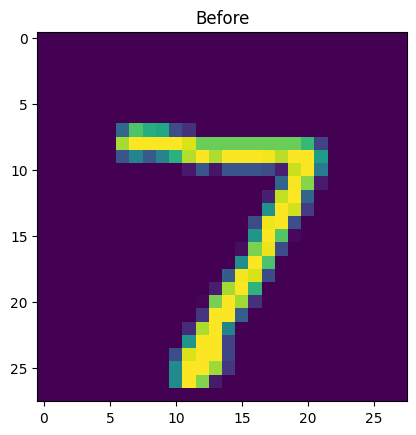

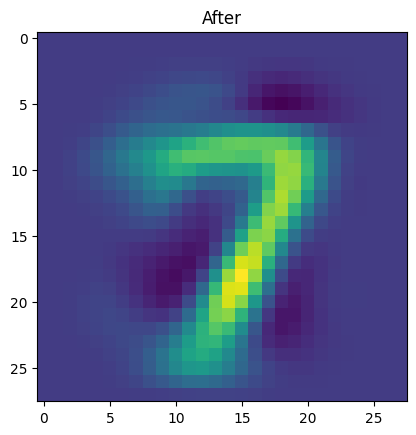

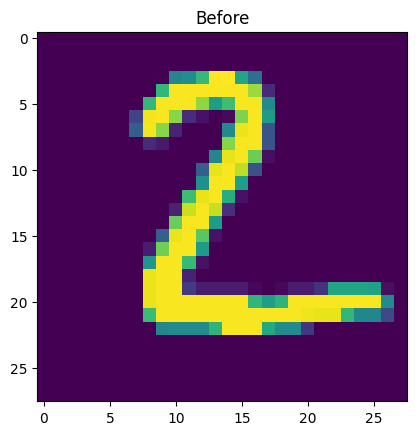

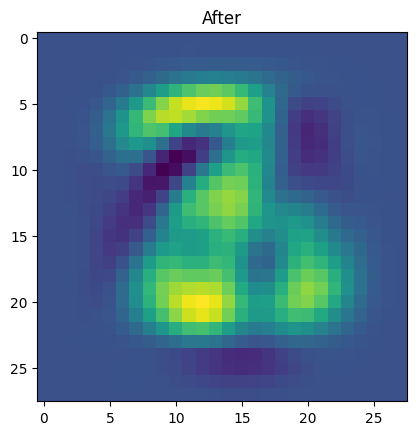

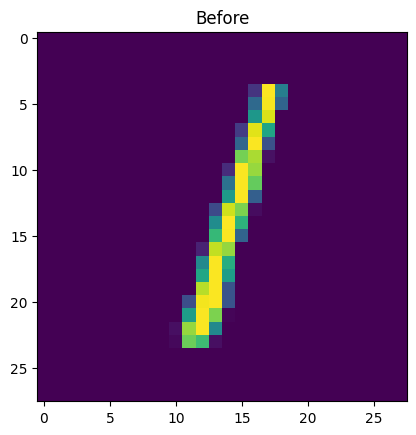

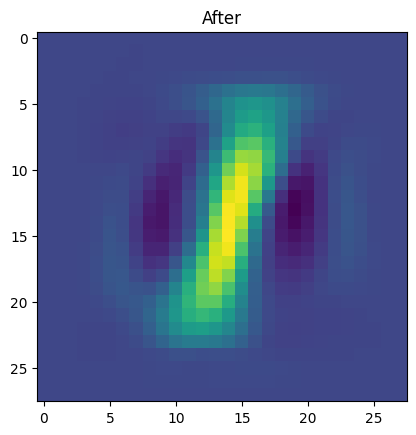

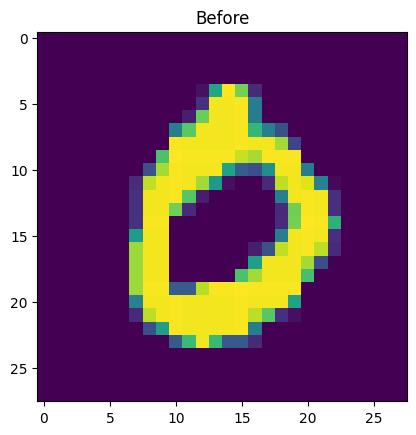

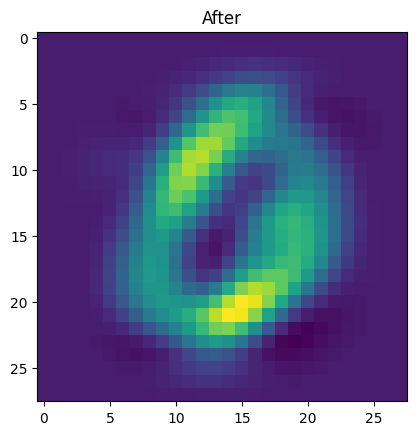

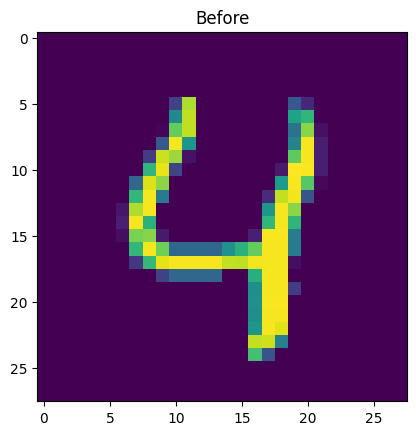

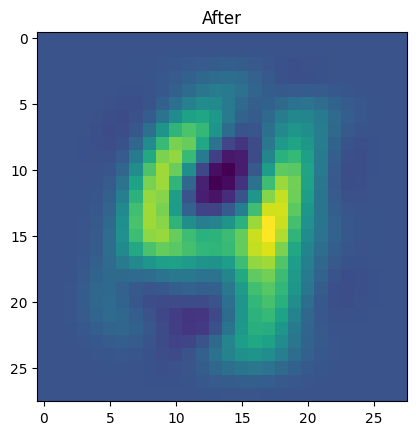

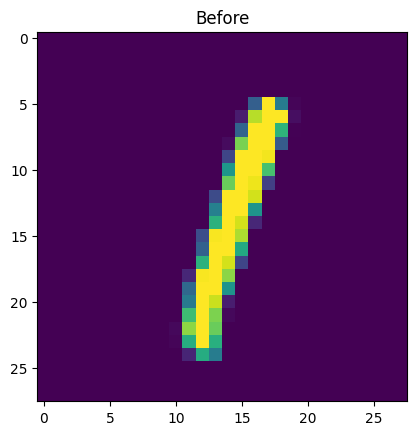

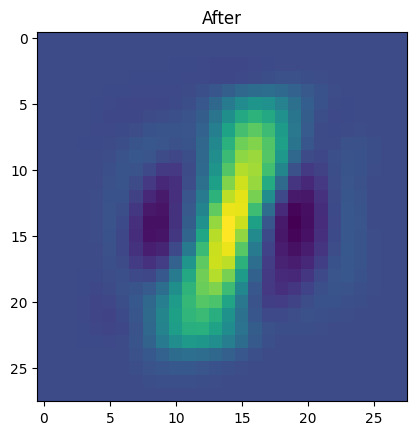

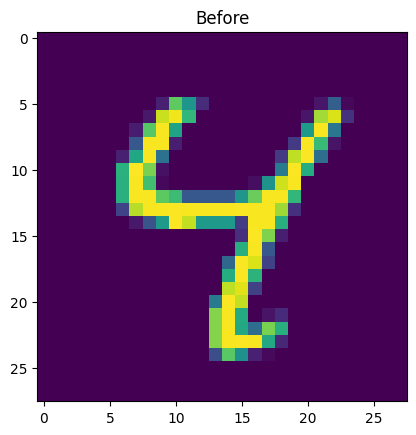

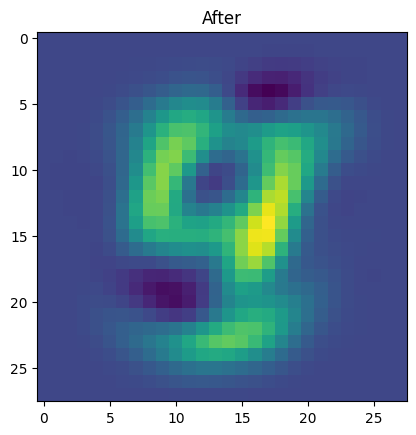

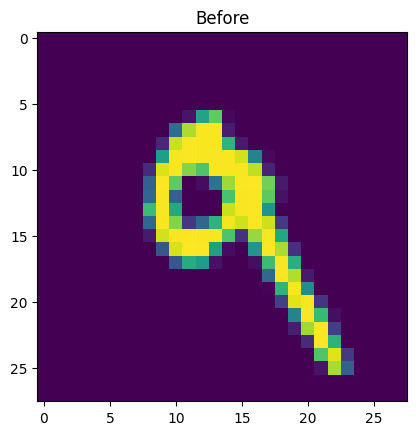

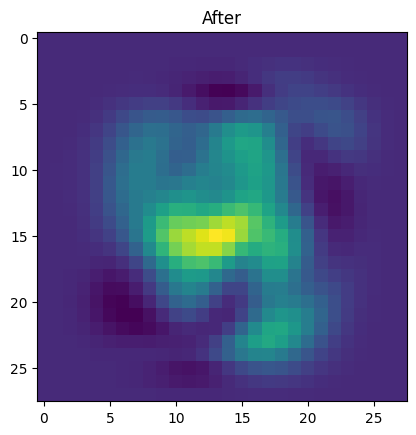

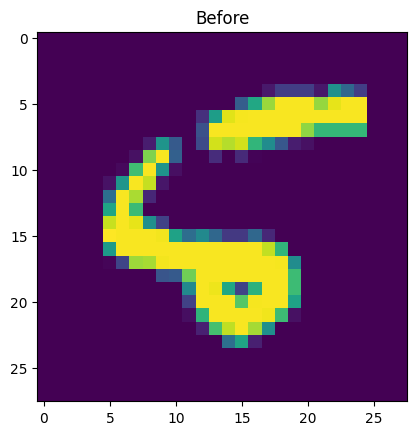

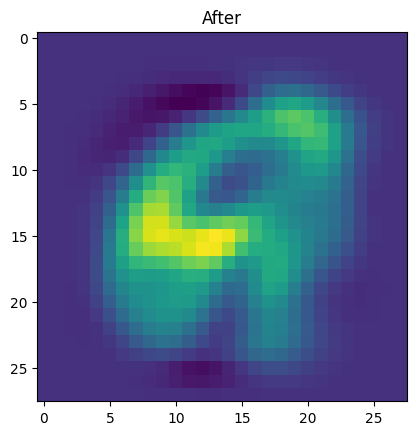

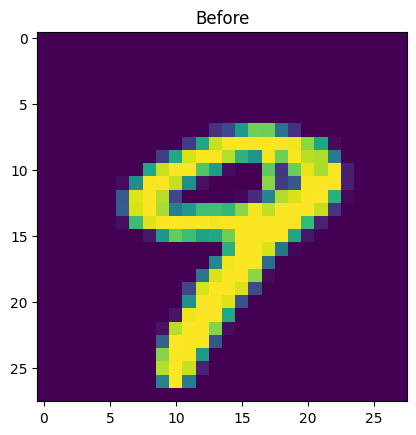

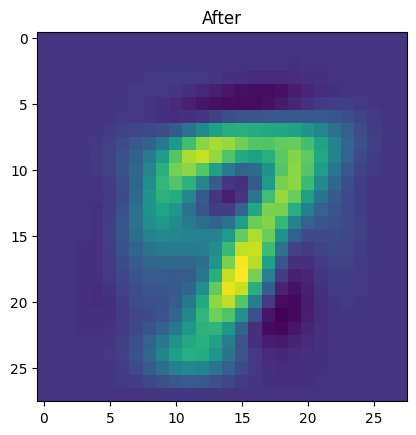

In [11]:
num_ex = 10

for i in range(num_ex):
    plt.figure()
    plt.title("Before")
    plt.imshow((X_test[:,i].reshape((X_test[:,i].size, 1))*stds+mu).reshape((28,28)))
    
    # Compute encoding
    z = B.T@X_test[:,i]

    # Compute decoding
    x_tilde = B@z

    plt.figure()
    plt.title("After")
    plt.imshow((x_tilde.reshape((x_tilde.size, 1))*stds+mu).reshape((28,28)))

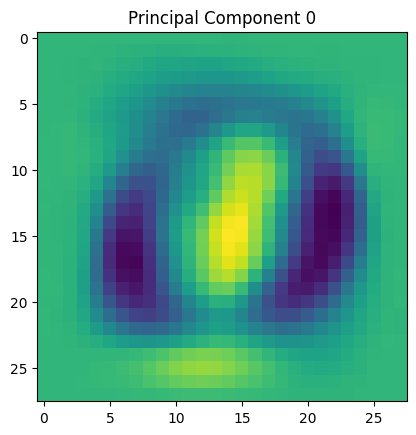

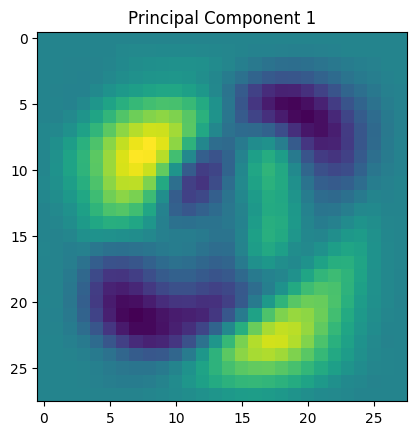

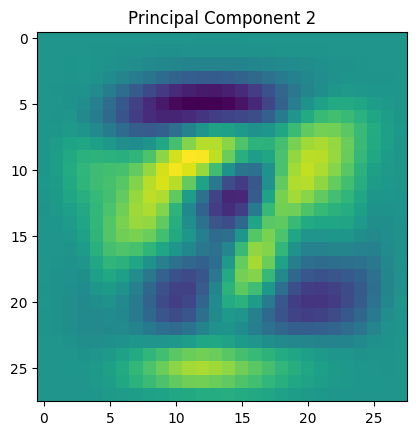

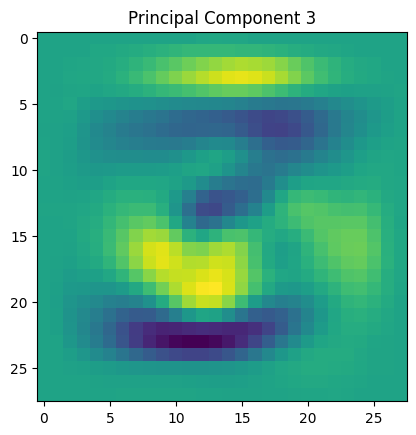

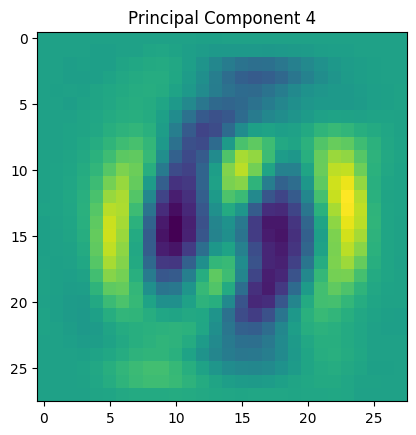

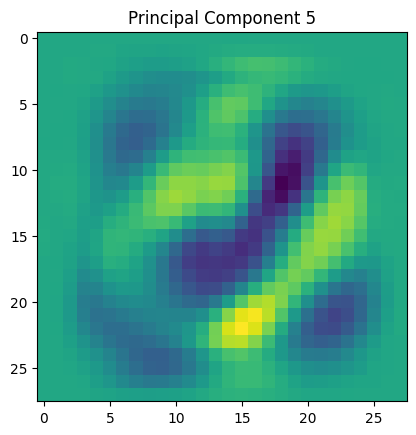

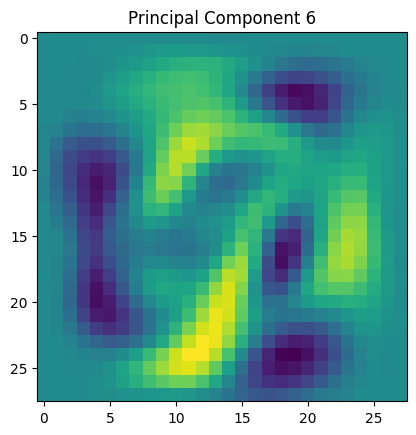

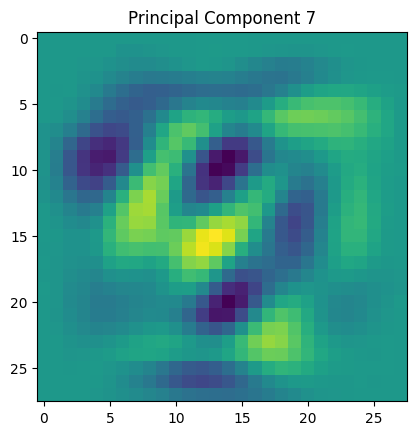

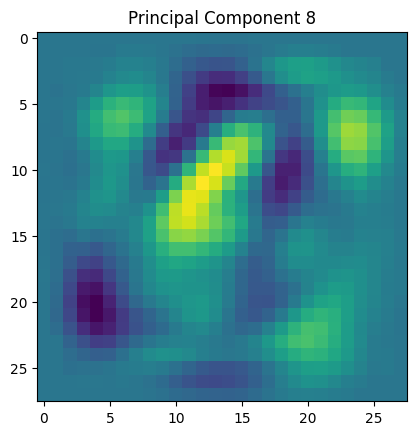

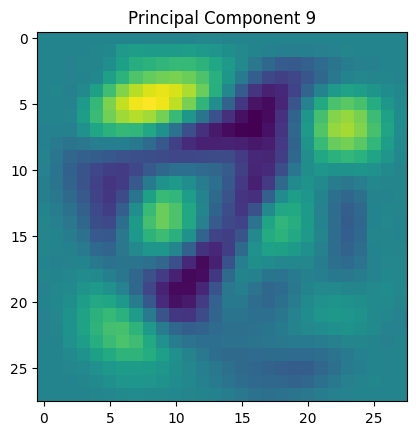

In [12]:
for i in range(B.shape[1]):
    plt.figure()
    plt.title(f"Principal Component {i}")
    plt.imshow(B[:,i].reshape((28,28)))

## 2D PCA Embedding Visualization

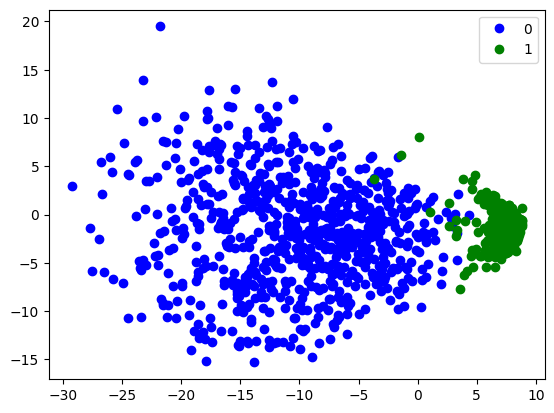

In [13]:
M = 2
B = ordered_eigvecs[:,:M]

num_ex = 750

plt.figure()

embeddings = []
for i in range(10):
    embeddings_i = []
    for j in range(num_ex):
        # Compute encoding
        z = B.T@Xs_test[i][0][:,j]
    
        embeddings_i.append(z)

    embeddings.append(embeddings_i)

embeddings = np.array(embeddings)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(2):
    plt.plot(embeddings[i,:,0], embeddings[i,:,1], f'{colors[i]}o', label=f"{i}")

plt.legend(loc ="best")

## Implementing Power Iteration for Finding Largest Eigenvector

Power iteration is an efficient iterative method used for finding the largest eigenvector of a matrix and is computed as follows:

$$\mathbf{x}_{k+1}=\frac{S\mathbf{x}_k}{\|S\mathbf{x}_k\|},\quad k=0,1,...$$

48
0.9999999999999998
1.0000000000000004
diff: 2.446012924378284e-07


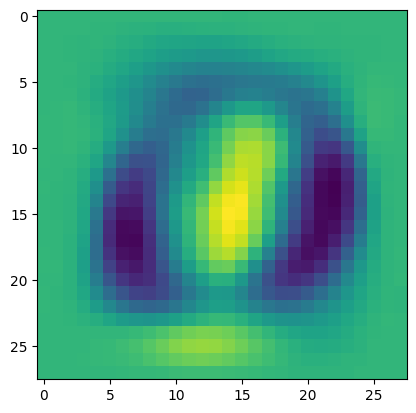

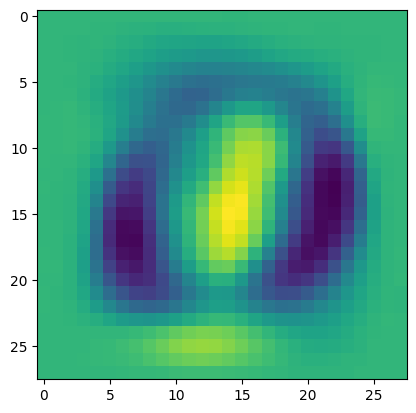

In [14]:
x_last = np.random.rand(S.shape[0],1)
x_new = None

# Power Iteration: Finds the largest eigenvalue iteratively
num_iter = 0
not_done = True
while not_done:
    proj = S@x_last
    x_new = proj / np.linalg.norm(proj)

    not_done = np.linalg.norm(x_new - x_last) > 1e-8
    x_last = -x_new
    num_iter += 1

print(num_iter)
plt.figure()
plt.imshow(x_new.reshape((28,28)))
print(np.linalg.norm(x_new))

plt.figure()
plt.imshow(B[:,0].reshape((28,28)))
print(np.linalg.norm(B[:,0]))

print(f"diff: {np.linalg.norm(S@x_new - ordered_eigvals[0]*x_new)}")

# TODO: Figure out why power iteration often produces negative eigenvector here

## Generative Ancestral Sampling Using Probabilistic Principal Component Analysis (PPCA)

We're interested in exploring the relationship between $\mathbf{x}$ and unobserved latent variables that live in a lower dimensional space. Letting $\mathbf{z}\in\mathbb{R}^D$ be the latent variable vector, we can describe $\mathbf{x}$ in terms of the latent data as follows: $$\mathbf{x}=\mathbf{Bz}+\mathbf{\mu}+\mathbf{\epsilon}$$ where $\mathbf{\epsilon}$ describes observation noise, $\mathbf{\epsilon}\sim\mathcal{N}(0,\;\sigma^2\mathbf{I})$, and $\mathbf{Bz}+\mathbf{\mu}$ describes the affine mapping from latent variables $\mathbf{z}$ to the observed data $\mathbf{x}$.

From the assumptions above, we can describe probabilistic PCA as: $$\mathbf{z}_n\sim\mathcal{N}(\mathbf{z}\;|\;0,\mathbf{I})$$
$$\mathbf{x}\;|\;\mathbf{z}_n\sim\mathcal{N}(\mathbf{x}_n\;|\;\mathbf{Bz}_n+\mathbf{\mu},\;\sigma^2\mathbf{I})$$

New data points can be drawn from this distribution using *ancestral sampling*. To do this, we first draw an example from $p(\mathbf{z})$, then we use this example to sample from $p(\mathbf{x}\;|\;\mathbf{z},\;\mathbf{B},\;\mathbf{\mu},\;\sigma^2)$.
So we have the probabilistic model: $$p(\mathbf{x},\;\mathbf{z}\;|\;\mathbf{B},\mathbf{\mu},\sigma^2)=p(\mathbf{x}\;|\;\mathbf{z},\mathbf{B},\mathbf{\mu},\sigma^2)p(\mathbf{z})$$.

### Starting with eights

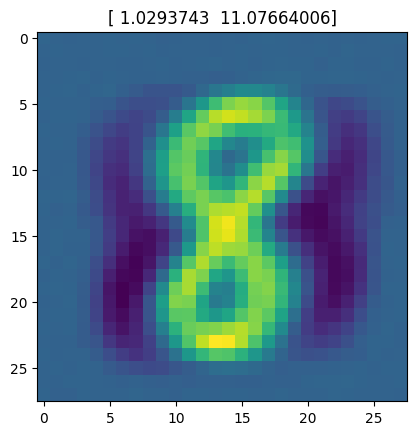

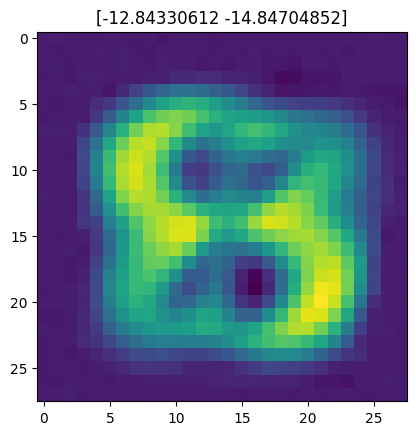

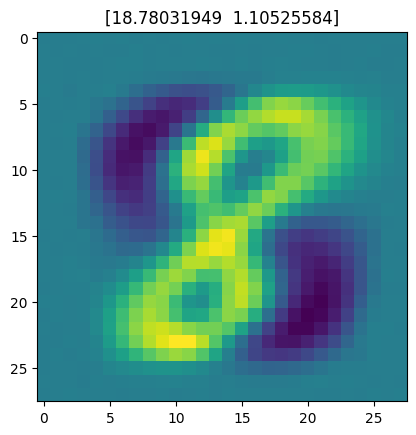

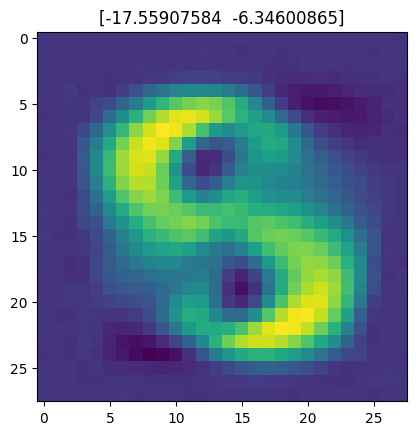

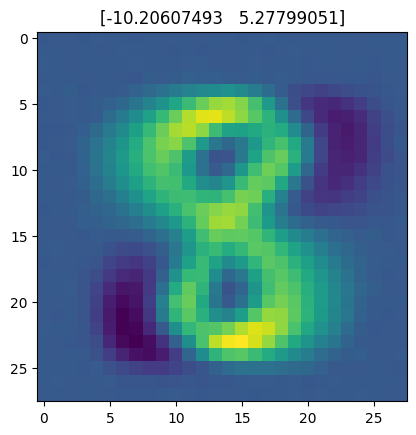

In [54]:
M = 2
strat_B = strat_ordered_eigvecs[:,:M]
mu = mus[8]
sigma = 1e-2

sample_size = 5

def sample_from_prior(latent_dim, sample_size):
    return np.random.multivariate_normal(np.zeros(latent_dim), 100*np.eye(latent_dim), size=sample_size)

def sample_from_posterior(prior_sample, B, mu, sigma):
    mean = B@prior_sample.T + mu
    cov = sigma**2*np.eye(B.shape[0])
    for i in range(prior_sample.shape[0]):
        yield (np.random.multivariate_normal(mean[:,i], cov), prior_sample[i,:])

def generate_examples(sample_size, latent_dim, B, mu, sigma):
    ''' PPCA via Ancestral Sampling '''
    prior_sample = sample_from_prior(M, sample_size)

    for example, z in sample_from_posterior(prior_sample, strat_B, mu, sigma):
        yield (example, z)

for (example, latent) in generate_examples(sample_size, M, strat_B, mu, sigma):
    plt.figure()
    plt.title(latent)
    plt.imshow(example.reshape((28,28)))
